# Custom Datasets

## Data Augmentation e Transforms no PyTorch

###  O que são Transforms?
- **Transforms** alteram as imagens antes de alimentá-las ao modelo.
- São usados para **preprocessamento** (ex: converter para tensor) e **data augmentation** (ex: rotação, recorte, etc.).
- Objetivo: **aumentar a diversidade dos dados de treino** para melhorar a **generalização** do modelo.

## Tipos de Data Augmentation
- **transforms.Resize((64, 64))** → Redimensiona para um tamanho fixo.
- **transforms.RandomHorizontalFlip(p=0.5)** → Espelha horizontalmente com 50% de chance.
- **transforms.RandomRotation(degrees=30)** → Rotaciona a imagem aleatoriamente.
- **transforms.RandomCrop(size=(32, 32))** → Recorta uma parte aleatória.
- **transforms.ColorJitter(brightness=0.2, contrast=0.2)** → Altera brilho e contraste.
- **transforms.TrivialAugmentWide(num_magnitude_bins=31)** → Aplica *augmentation* de forma **aleatória e intensa**.


## Observações:
- **Data Augmentation só no treino** → O teste deve refletir o mundo real.
- **ToTensor() sempre por último** → Converte para tensor e normaliza os pixels (0-255 → 0.0-1.0).
- **Mais *augmentation* pode melhorar modelos**

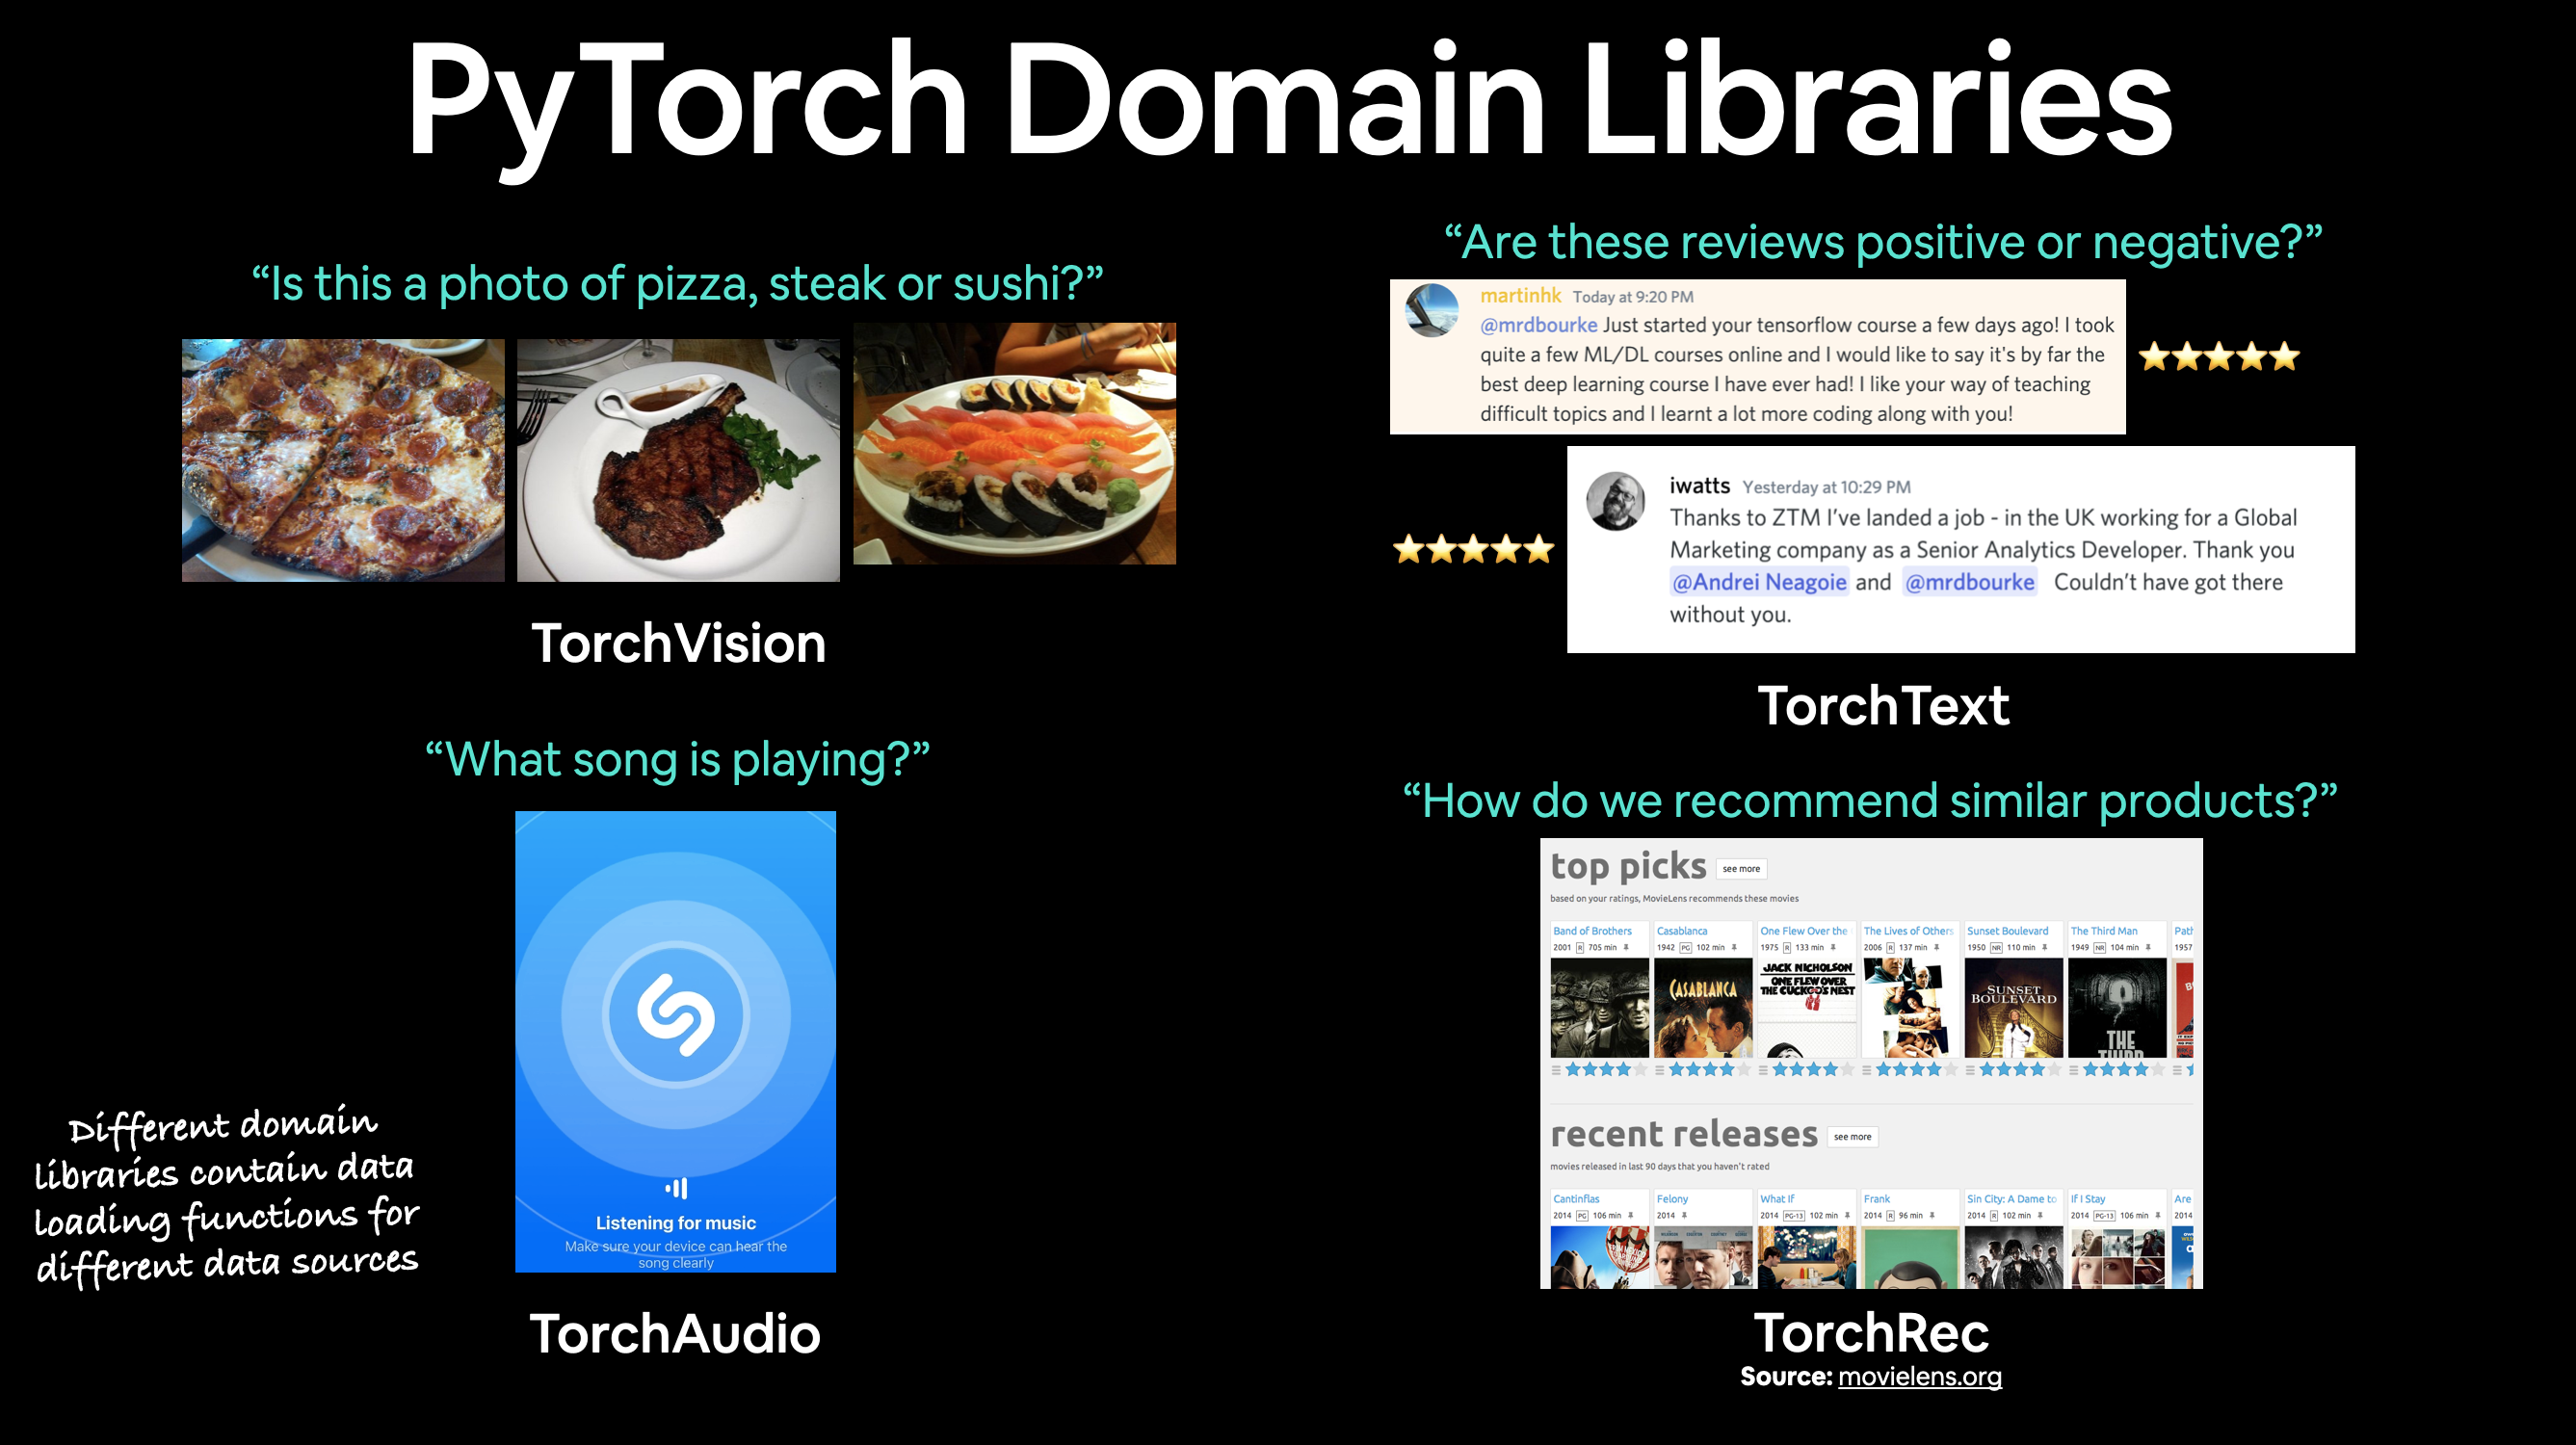

In [10]:
import torch
from torch import nn
import requests
import zipfile
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Dataset

In [3]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data\pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## Visualizar Imagens

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


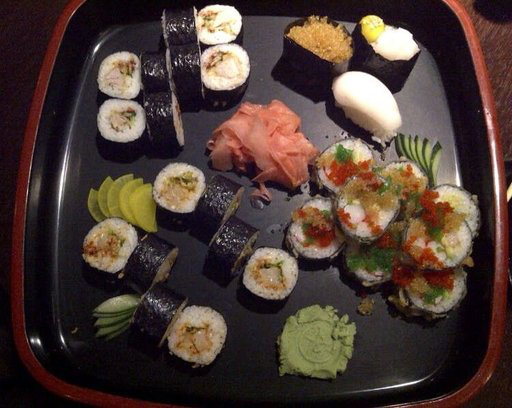

In [6]:
import random
from PIL import Image

random.seed(42)

# pegra todos os paths de imagens
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)

# imagem aleatoria
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

## Transformação de Dados

In [8]:
data_transform = transforms.Compose([ # junta várias transformações dentro de uma lista
                transforms.Resize(size=(64, 64)), # redimensiona e padroniza tamanho
                transforms.RandomHorizontalFlip(p=0.5), # espelha com chance de 50%
                transforms.ToTensor() # converte pra um tensor
])              


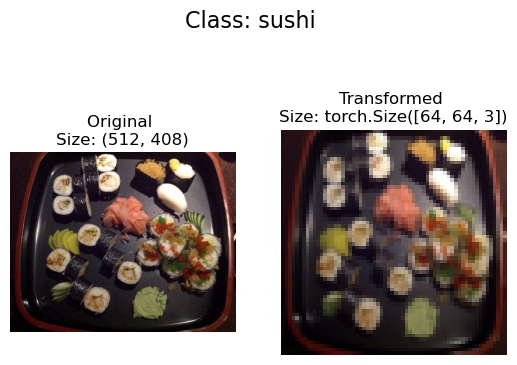

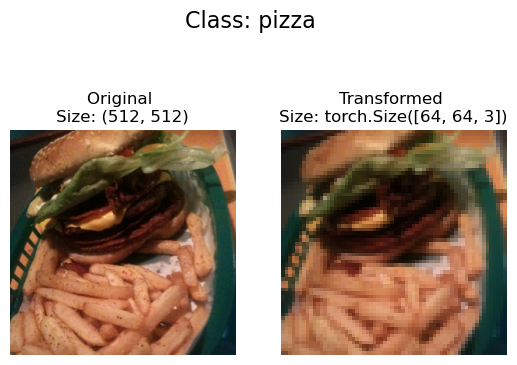

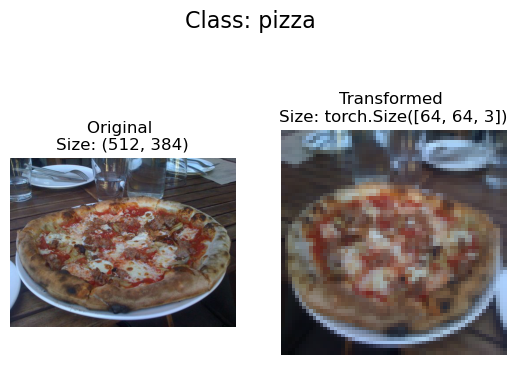

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

## Opção 2: Carregamento de Dados

In [13]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, 
                                  target_transform=None) 

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


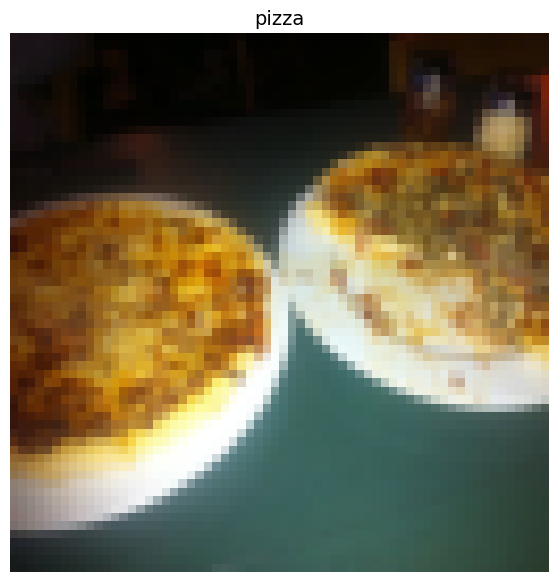

In [15]:
img, label = train_data[0][0], train_data[0][1]

# rearranja ordem das dimensoes
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);